In [1]:
from herbert_emotion_classifier.dataset import EmotionsInTextDataset 

from herbert_emotion_classifier.model import HerbertEmotionClassifier
from herbert_emotion_classifier.datamodule import EmotionsInTextDatamodule

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

from os.path import join

import pandas as pd

In [2]:
model = HerbertEmotionClassifier()

In [3]:
train_ds = EmotionsInTextDataset(join("..", "data", "slowosiec_all_data_embeddings.pickle"))
# train_ds = EmotionsInTextSlowosieclineDataset(join("..", "data", "wust_train_embeddings.pickle"))

val_ds = EmotionsInTextDataset(join("..", "data", "wust_test_embeddings.pickle"))

In [4]:
dm = EmotionsInTextDatamodule(16, train_ds, val_ds)

In [5]:
batch = next(iter(dm.val_dataloader()))

In [6]:
batch.get("sentence_embedding").size()

torch.Size([16, 768])

In [7]:
# logger = WandbLogger(name="unet_resnet50",project="pst_segmentation")

seed_everything(42)

trainer = Trainer(max_epochs=100,
                  gpus=1,
                  deterministic=True,
                  accumulate_grad_batches=4,
                  checkpoint_callback=False,
                  callbacks=[EarlyStopping(monitor='val/loss')],
                  logger=False
                  )

trainer.fit(model, dm)

model.eval()
a=1
# model.freeze()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | criterion  | CrossEntropyLoss | 0     
1 | classifier | Sequential       | 230 K 


In [8]:
from herbert_emotion_classifier.predict import predict
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

In [9]:
import torch

def predict(model, dataloader, device):
    """
    :param model:
    :param dataloader:
    :param device:
    :param get_x_fun:
    :return:
    """
    model = model.to(device)

    num_elements = len(dataloader.dataset)
    num_batches = len(dataloader)

    batch_size = dataloader.batch_size

    predictions = torch.zeros(num_elements)
    true_labels = torch.zeros(num_elements)

    for i, batch in enumerate(dataloader):
        start = i * batch_size
        end = start + batch_size
        if i == num_batches - 1:
            end = num_elements

        x = batch["sentence_embedding"]
        y = batch["label"]
        logits = model.forward(x.to(device))
        pred = torch.argmax(logits, dim=1)
        predictions[start:end] = pred.detach()
        true_labels[start:end] = y.detach()

    return predictions, true_labels

In [10]:
predictions, true_labels = predict(model, dm.val_dataloader(), "cuda")

In [11]:
class_names = ['oczekiwanie', 'podziw', 'radosc', 'smutek', 'strach', 'wstret', 'zaskoczenie', 'zlosc', 'neutralne']

<AxesSubplot:>

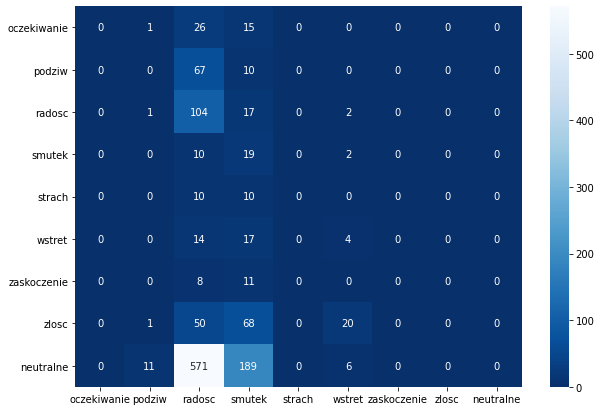

In [12]:
cm = confusion_matrix(true_labels, predictions)
df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                  columns = [i for i in class_names])

plt.figure(figsize = (10,7))

sn.heatmap(df_cm, cmap="Blues_r", annot=True, fmt="d")

In [13]:
print(classification_report(true_labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

 oczekiwanie       0.00      0.00      0.00        42
      podziw       0.00      0.00      0.00        77
      radosc       0.12      0.84      0.21       124
      smutek       0.05      0.61      0.10        31
      strach       0.00      0.00      0.00        20
      wstret       0.12      0.11      0.12        35
 zaskoczenie       0.00      0.00      0.00        19
       zlosc       0.00      0.00      0.00       139
   neutralne       0.00      0.00      0.00       777

   micro avg       0.10      0.10      0.10      1264
   macro avg       0.03      0.17      0.05      1264
weighted avg       0.02      0.10      0.03      1264



/anaconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/jupyterhub/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
